In [1]:
!pip install deepface chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 64.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 64.1 MB/s eta 0:00:00:00:0100:01

In [2]:
import cv2
import matplotlib.pyplot as plt
import warnings
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from deepface import DeepFace
from sklearn.metrics import classification_report
import chromadb
import uuid
import random
warnings.filterwarnings('ignore')

2025-06-29 08:41:15.238080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751186475.511370      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751186475.588393      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


25-06-29 08:41:31 - Directory /root/.deepface has been created
25-06-29 08:41:31 - Directory /root/.deepface/weights has been created


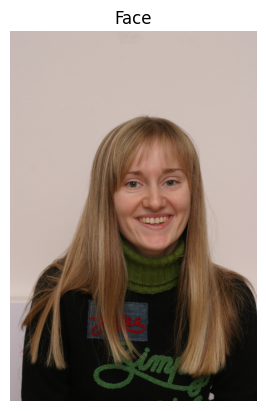

In [3]:
img = Image.open("/kaggle/input/facecom/Comys_Hackathon5/Task_A/train/female/007_frontal.jpg")
plt.imshow(img)
plt.axis('off')
plt.title("Face")
plt.show()

In [4]:
def load_images_from_folder(folder_path, exts={'.jpg', '.jpeg', '.png'}):
    images = []
    for filename in tqdm(os.listdir(folder_path), desc=os.path.basename(folder_path)):
        if os.path.splitext(filename)[1].lower() in exts:
            path = os.path.join(folder_path, filename)
            try:
                img = Image.open(path).convert('RGB')
                images.append(np.array(img))
            except:
                pass
    return images

base_dir = "/kaggle/input/facecom/Comys_Hackathon5/Task_A/train"

data = {
    "female": load_images_from_folder(os.path.join(base_dir, "female")),
    "male": load_images_from_folder(os.path.join(base_dir, "male"))
}
print(f"✅ Loaded {len(data['female'])} female images.")
print(f"✅ Loaded {len(data['male'])} male images.")

male: 100%|██████████| 1623/1623 [00:17<00:00, 94.68it/s] 

✅ Loaded 303 female images.
✅ Loaded 1623 male images.


In [5]:
len(data)

2

In [6]:
def preprocess_faces(data, target_size=(112, 112)):
    def lighting_normalization(img):
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    def denoise(img):
        return cv2.fastNlMeansDenoisingColored(img, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)

    processed = {}
    for person in data:
        images = data[person]
        processed_images = []
        for img in tqdm(images, desc=f"Processing {person}"):
            img = denoise(img)
            img = lighting_normalization(img)
            img = cv2.resize(img, target_size)
            processed_images.append(img)
        processed[person] = processed_images

    return processed

In [7]:
# processed_data = preprocess_faces(data)

In [8]:
# def show_before_after(original, processed, title="Preprocessing Comparison"):
#     plt.figure(figsize=(8, 4))
#     plt.subplot(1, 2, 1)
#     plt.imshow(original)
#     plt.title("Before")
#     plt.axis('off')
    
#     plt.subplot(1, 2, 2)
#     plt.imshow(processed)
#     plt.title("After")
#     plt.axis('off')
    
#     plt.suptitle(title)
#     plt.tight_layout()
#     plt.show()

# original = data['female'][0]
# processed = processed_data['female'][0]

# show_before_after(original, processed)

In [9]:
DeepFace.analyze(img_path=data['female'][0], actions=["age", "gender", "emotion", "race"])[0]['gender']

Action: age:   0%|          | 0/4 [00:00<?, ?it/s]    2025-06-29 08:41:56.026336: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


25-06-29 08:41:57 - age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5

  0%|          | 0.00/539M [00:00<?, ?B/s]
  2%|▏         | 11.0M/539M [00:00<00:06, 87.5MB/s]
  4%|▍         | 21.5M/539M [00:00<00:05, 94.3MB/s]
  6%|▌         | 32.0M/539M [00:00<00:05, 88.5MB/s]
  8%|▊         | 42.5M/539M [00:00<00:06, 71.7MB/s]
 10%|▉         | 53.0M/539M [00:00<00:06, 72.1MB/s]
 12%|█▏        | 63.4M/539M [00:00<00:05, 79.6MB/s]
 14%|█▎        | 73.9M/539M [00:00<00:06, 69.6MB/s]
 16%|█▌        | 84.4M/539M [00:01<00:06, 74.9MB/s]
 18%|█▊        | 94.9M/539M [00:01<00:05, 80.8MB/s]
 20%|█▉        | 105M/539M [00:01<00:05, 83.8MB/s] 
 22%|██▏       | 116M/539M [00:01<00:04, 86.1MB/s]
 23%|██▎       | 126M/539M [00:01<00:04, 90.7MB/s]
 26%|██▌       | 138M/539M [00:01<00:04, 97.2MB/s]
 28%|██▊       | 149M/539M [00:01<00:03, 100MB/s] 
 30%|██▉       | 159M/539M [00:01<00:04, 94.6MB/s]
 31%|███▏      | 169M/5

25-06-29 08:42:08 - gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5

  0%|          | 0.00/537M [00:00<?, ?B/s]
  2%|▏         | 11.0M/537M [00:00<00:05, 90.1MB/s]
  4%|▍         | 21.5M/537M [00:00<00:05, 97.0MB/s]
  6%|▌         | 32.0M/537M [00:00<00:05, 96.7MB/s]
  8%|▊         | 44.0M/537M [00:00<00:04, 105MB/s] 
 10%|█         | 55.1M/537M [00:00<00:06, 69.2MB/s]
 12%|█▏        | 63.4M/537M [00:00<00:06, 72.3MB/s]
 14%|█▍        | 73.9M/537M [00:00<00:05, 77.3MB/s]
 16%|█▌        | 84.4M/537M [00:01<00:05, 83.6MB/s]
 18%|█▊        | 94.9M/537M [00:01<00:05, 87.3MB/s]
 20%|██        | 108M/537M [00:01<00:04, 99.1MB/s] 
 23%|██▎       | 124M/537M [00:01<00:03, 115MB/s] 
 25%|██▌       | 137M/537M [00:01<00:04, 98.8MB/s]
 28%|██▊       | 148M/537M [00:01<00:05, 73.1MB/s]
 29%|██▉       | 158M/537M [00:01<00:04, 78.1MB/s]
 31%|███▏      | 168M/537M [00:01<00:04, 81.2MB/s]
 33%|███▎      | 

25-06-29 08:42:19 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5

100%|██████████| 5.98M/5.98M [00:00<00:00, 144MB/s]
Action: race:  75%|███████▌  | 3/4 [00:24<00:06,  6.75s/it]   

25-06-29 08:42:21 - race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: /root/.deepface/weights/race_model_single_batch.h5

  0%|          | 0.00/537M [00:00<?, ?B/s]
  2%|▏         | 11.0M/537M [00:00<00:05, 89.1MB/s]
  4%|▍         | 21.5M/537M [00:00<00:06, 75.8MB/s]
  6%|▌         | 32.0M/537M [00:00<00:06, 84.1MB/s]
  8%|▊         | 43.0M/537M [00:00<00:05, 92.8MB/s]
 10%|▉         | 53.0M/537M [00:00<00:05, 94.0MB/s]
 12%|█▏        | 63.4M/537M [00:00<00:05, 85.3MB/s]
 14%|█▍        | 76.0M/537M [00:00<00:04, 96.7MB/s]
 16%|█▌        | 86.5M/537M [00:00<00:04, 97.9MB/s]
 18%|█▊        | 97.0M/537M [00:01<00:04, 95.5MB/s]
 20%|█▉        | 107M/537M [00:01<00:04, 95.8MB/s] 
 22%|██▏       | 117M/537M [00:01<00:04, 95.8MB/s]
 24%|██▎       | 127M/537M [00:01<00:04, 98.2MB/s]
 26%|██▌       | 139M/537M [00:01<00:03, 105MB/s] 
 28%|██▊       | 150M/537M [00:01<00:03, 103MB/s]
 30%|██▉       | 161M/537M [00:01<00:04, 85.6MB/s]
 32%|███▏   

{'Woman': 100.0, 'Man': 3.957905647666848e-06}

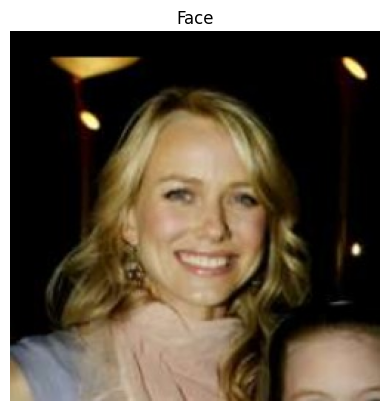

In [10]:
plt.imshow(data['female'][0])
plt.axis('off')
plt.title("Face")
plt.show()

In [11]:
y_true = []
y_pred = []

for img in tqdm(data['female'], desc='Processing female', total=len(data['female'])):
    try:
        gender_pred = DeepFace.analyze(img_path=img, actions=["gender"], detector_backend='skip')[0]['gender']
        predicted = 'female' if gender_pred['Woman'] > gender_pred['Man'] else 'male'
        y_true.append('female')
        y_pred.append(predicted)
    except Exception as e:
        continue

for img in tqdm(data['male'], desc='Processing male', total=len(data['male'])):
    try:
        gender_pred = DeepFace.analyze(img_path=img, actions=["gender"], detector_backend='skip')[0]['gender']
        predicted = 'female' if gender_pred['Woman'] > gender_pred['Man'] else 'male'
        y_true.append('male')
        y_pred.append(predicted)
    except Exception as e:
        continue

print(classification_report(y_true, y_pred, digits=4))

Processing male: 100%|██████████| 1623/1623 [12:24<00:00,  2.18it/s]

              precision    recall  f1-score   support

      female     0.7540    0.9307    0.8331       303
        male     0.9865    0.9433    0.9644      1623

    accuracy                         0.9413      1926
   macro avg     0.8702    0.9370    0.8987      1926
weighted avg     0.9499    0.9413    0.9437      1926



In [ ]:
def load_images_from_folder(folder_path, exts={'.jpg', '.jpeg', '.png'}):
    images = []
    all_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in exts:
                all_files.append(os.path.join(root, file))
    
    for file_path in tqdm(all_files, desc=os.path.basename(folder_path), leave=False):
        try:
            img = Image.open(file_path).convert('RGB')
            images.append(np.array(img))
        except:
            pass
    return images

base_dir = "/kaggle/input/facecom/Comys_Hackathon5/Task_B/train"

data = {}
for person_folder in tqdm(os.listdir(base_dir), desc="Loading folders"):
    folder_path = os.path.join(base_dir, person_folder)
    if os.path.isdir(folder_path):
        data[person_folder] = load_images_from_folder(folder_path)

# Summary
for k, v in data.items():
    print(f"✅ Loaded {len(v)} images for '{k}'")

Ralph_Sampson:   0%|          | 0/8 [00:00<?, ?it/s]
                                                    
Emyr_Jones_Parry:   0%|          | 0/8 [00:00<?, ?it/s]
                                                       
Anthony_Lee_Johnson:   0%|          | 0/8 [00:00<?, ?it/s]
                                                          
James_Carville:   0%|          | 0/8 [00:00<?, ?it/s]
                                                     
David_Przybyszewski:   0%|          | 0/8 [00:00<?, ?it/s]
                                                          
Tommy_Shane_Steiner:   0%|          | 0/8 [00:00<?, ?it/s]
                                                          
Conchita_Martinez:  96%|█████████▌| 23/24 [00:00<00:00, 228.80it/s]
                                                                   
Alejandro_Atchugarry:   0%|          | 0/16 [00:00<?, ?it/s]
                                                            
068_frontal: 100%|██████████| 8/8 [00:00<00:00, 10.94it/s]
   

In [13]:
processed_data = preprocess_faces(data)

Processing Valerie_Harper: 100%|██████████| 16/16 [00:03<00:00,  4.31it/s]


In [14]:
chroma_client = chromadb.Client()
collection = chroma_client.get_or_create_collection(name="faces")

def l2_normalize(x):
    return x / np.linalg.norm(x)

def store_embeddings(processed_data):
    for label, img_list in tqdm(processed_data.items(), desc='Storing in ChromaDB'):
        for i, img in enumerate(img_list):
            embedding = DeepFace.represent(
                img_path=img,
                model_name='ArcFace',
                detector_backend='skip',
                enforce_detection=False
            )[0]["embedding"]
            embedding = l2_normalize(np.array(embedding))

            collection.add(
                documents=[label],
                embeddings=[embedding.tolist()],
                ids=[f"{label}_{i}"]
            )

In [15]:
store_embeddings(processed_data)

Storing in ChromaDB:   0%|          | 0/877 [00:00<?, ?it/s]

25-06-29 12:24:43 - arcface_weights.h5 will be downloaded to /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5

  0%|          | 0.00/137M [00:00<?, ?B/s]
  8%|▊         | 11.0M/137M [00:00<00:01, 84.9MB/s]
 15%|█▍        | 19.9M/137M [00:00<00:01, 64.1MB/s]
 20%|█▉        | 26.7M/137M [00:00<00:02, 49.6MB/s]
 23%|██▎       | 32.0M/137M [00:00<00:02, 41.6MB/s]
 29%|██▉       | 40.4M/137M [00:00<00:02, 45.0MB/s]
 33%|███▎      | 45.1M/137M [00:00<00:02, 44.0MB/s]
 37%|███▋      | 50.9M/137M [00:01<00:02, 43.0MB/s]
 41%|████      | 55.6M/137M [00:01<00:01, 42.6MB/s]
 45%|████▍     | 61.3M/137M [00:01<00:01, 41.0MB/s]
 48%|████▊     | 65.5M/137M [00:01<00:01, 40.1MB/s]
 52%|█████▏    | 71.3M/137M [00:01<00:01, 40.5MB/s]
 55%|█████▌    | 75.5M/137M [00:01<00:01, 33.3MB/s]
 60%|█████▉    | 81.8M/137M [00:01<00:01, 39.3MB/s]
 63%|██████▎   | 86.5M/137M [00:02<00:01, 36.7MB/s]
 68%|██████▊   | 92.8M/137M [00:02<00:01, 37.8MB/s]
 71%|███████   | 97.0M

In [16]:
# def query_face(img, top_k=3):
#     embedding = DeepFace.represent(img_path=img, model_name='ArcFace', detector_backend='skip')[0]["embedding"]
#     results = collection.query(query_embeddings=[embedding], n_results=top_k)
#     return results

In [17]:
def recognize_person(query_img):
    query_embedding = DeepFace.represent(
        img_path=query_img,
        model_name='ArcFace',
        detector_backend='skip',
        enforce_detection=False
    )[0]["embedding"]
    query_embedding = l2_normalize(np.array(query_embedding))

    results = collection.query(
        query_embeddings=[query_embedding.tolist()],
        n_results=5
    )

    top_docs = results['documents'][0]
    from collections import Counter
    label_counts = Counter(top_docs)
    best_match = label_counts.most_common(1)[0][0]

    return best_match


In [18]:
all_images = [(label, img) for label, imgs in processed_data.items() for img in imgs]
test_data = random.sample(all_images, k=1000)
len(test_data)

1000

In [20]:
y_true = []
y_pred = []

for person_label, img in tqdm(test_data, desc="🔍 Testing images"):
    try:
        pred = recognize_person(img)
        y_true.append("recognized")
        y_pred.append("recognized" if pred == person_label else "not_recognized")

    except Exception as e:
        print(f"❌ Error for {person_label}: {e}")
        continue
cnt = 0
for x,y in zip(y_true,y_pred):
    if x==y:
        cnt+=1

(cnt/len(y_true))*100

🔍 Testing images: 100%|██████████| 1000/1000 [05:18<00:00,  3.14it/s]


93.60000000000001

In [21]:
cnt

936

In [22]:
print(classification_report(
    y_true,
    y_pred,
    labels=['recognized', 'not_recognized'],
    zero_division=0
))

                precision    recall  f1-score   support

    recognized       1.00      0.94      0.97      1000
not_recognized       0.00      0.00      0.00         0

      accuracy                           0.94      1000
     macro avg       0.50      0.47      0.48      1000
  weighted avg       1.00      0.94      0.97      1000



In [23]:
base_dir = "/kaggle/input/facecom/Comys_Hackathon5/Task_B/val"

data_val = {}
for person_folder in tqdm(os.listdir(base_dir), desc="Loading folders"):
    folder_path = os.path.join(base_dir, person_folder)
    if os.path.isdir(folder_path):
        data_val[person_folder] = load_images_from_folder(folder_path)

Kai-Uwe_Ricke:   0%|          | 0/8 [00:00<?, ?it/s]
                                                    
Mohammed_Abu_Sharia:   0%|          | 0/8 [00:00<?, ?it/s]
                                                          
Alanis_Morissette:   0%|          | 0/8 [00:00<?, ?it/s]
                                                        
James_Hoffa:   0%|          | 0/8 [00:00<?, ?it/s]
                                                  
Troy_Aikman:   0%|          | 0/8 [00:00<?, ?it/s]
                                                  
Mia_Mottley:   0%|          | 0/8 [00:00<?, ?it/s]
                                                  
Fernando_Valenzuela:   0%|          | 0/8 [00:00<?, ?it/s]
                                                          
Mario_Lobo_Zagallo:   0%|          | 0/8 [00:00<?, ?it/s]
                                                         
Christian_Von_Wernich:   0%|          | 0/8 [00:00<?, ?it/s]
                                                            


In [24]:
processed_data_val = preprocess_faces(data_val)

Processing Raaf_Schefter: 100%|██████████| 8/8 [00:01<00:00,  4.34it/s]


In [25]:
store_embeddings(processed_data_val)

Storing in ChromaDB: 100%|██████████| 250/250 [19:20<00:00,  4.64s/it] 


In [26]:
all_images = [(label, img) for label, imgs in processed_data_val.items() for img in imgs]
test_data = random.sample(all_images, k=1000)
len(test_data)

1000

In [27]:
y_true = []
y_pred = []

for person_label, img in tqdm(test_data, desc="🔍 Testing images"):
    try:
        pred = recognize_person(img)
        y_true.append("recognized")
        y_pred.append("recognized" if pred == person_label else "not_recognized")

    except Exception as e:
        print(f"❌ Error for {person_label}: {e}")
        continue
cnt = 0
for x,y in zip(y_true,y_pred):
    if x==y:
        cnt+=1

(cnt/len(y_true))*100

🔍 Testing images: 100%|██████████| 1000/1000 [05:29<00:00,  3.03it/s]


93.7

In [28]:
print(classification_report(
    y_true,
    y_pred,
    labels=['recognized', 'not_recognized'],
    zero_division=0
))

                precision    recall  f1-score   support

    recognized       1.00      0.94      0.97      1000
not_recognized       0.00      0.00      0.00         0

      accuracy                           0.94      1000
     macro avg       0.50      0.47      0.48      1000
  weighted avg       1.00      0.94      0.97      1000



In [32]:
collection

Collection(name=faces)

In [33]:
chroma_client

In [38]:
import json
import numpy as np

def make_json_serializable(obj):
    """Recursively convert all numpy arrays in the structure to lists."""
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_json_serializable(i) for i in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

all_docs = collection.get(include=["embeddings", "metadatas", "documents"])

# Convert all numpy arrays to JSON-safe types
serializable_docs = make_json_serializable(all_docs)

# Save to file
with open("/kaggle/working/faces_collection.json", "w") as f:
    json.dump(serializable_docs, f)


In [40]:
print("📌 First 10 IDs:")
print(all_docs['ids'][:10])

print("\n📌 First 10 Embeddings:")
print(all_docs['embeddings'][:10])

print("\n📌 First 10 Documents:")
print(all_docs['documents'][:10])

print("\n📌 First 10 Metadatas:")
print(all_docs['metadatas'][:10])

📌 First 10 IDs:
['Ralph_Sampson_0', 'Ralph_Sampson_1', 'Ralph_Sampson_2', 'Ralph_Sampson_3', 'Ralph_Sampson_4', 'Ralph_Sampson_5', 'Ralph_Sampson_6', 'Ralph_Sampson_7', 'Colin_Powell_0', 'Colin_Powell_1']

📌 First 10 Embeddings:
[[-0.00550873  0.05934929 -0.01117996 ...  0.00103784 -0.04483627
  -0.12951303]
 [-0.02048228  0.06297859 -0.01573213 ... -0.00143305 -0.04463138
  -0.12261722]
 [-0.01153778  0.06128117 -0.01300541 ... -0.00378571 -0.04625278
  -0.12701647]
 ...
 [-0.01779545  0.06650575  0.00264094 ...  0.00227546 -0.05169284
  -0.12718029]
 [-0.01673731  0.0348829   0.0079187  ...  0.00301328 -0.03753493
  -0.13571174]
 [-0.02331199  0.0698548  -0.01793818 ...  0.002041   -0.03974241
  -0.13094023]]

📌 First 10 Documents:
['Ralph_Sampson', 'Ralph_Sampson', 'Ralph_Sampson', 'Ralph_Sampson', 'Ralph_Sampson', 'Ralph_Sampson', 'Ralph_Sampson', 'Ralph_Sampson', 'Colin_Powell', 'Colin_Powell']

📌 First 10 Metadatas:
[None, None, None, None, None, None, None, None, None, None]


In [41]:
!pip freeze > requirements.txt

In [ ]:
import time

while True:
    print('Yes')
    time.sleep(300)

Yes
